In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from helper import unet
from helper import augmentData
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate, Flatten, Dropout

2025-04-09 11:53:25.855858: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 11:53:26.054173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744192406.121786   22018 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744192406.141027   22018 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744192406.281770   22018 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
def load_images(image_dir, mask_dir):
    images, masks = [], []

    for i in range(len(os.listdir(image_dir))):
        image = cv2.imread(image_dir + f'image_{i}.jpg')
        image = cv2.resize(image, (128,128))
        images.append(image)
    for i in range(len(os.listdir(mask_dir))):
        mask = cv2.imread(mask_dir + f'image_{i}_mask.png')
        binary_mask = np.where(mask > 0, 255, mask)
        binary_mask = cv2.resize(binary_mask, (128, 128))
        masks.append(binary_mask)
    return images, masks
    # for file in os.listdir(image_dir):
    #     if file.endswith('.jpg'):
    #         image = cv2.imread(image_dir + file,cv2.IMREAD_GRAYSCALE)
    #         # image = cv2.resize(image, (128,128))
    #         images.append(image)
    # for file in os.listdir(mask_dir):
    #     if file.endswith('.png'):
    #         mask = cv2.imread(mask_dir + file,cv2.IMREAD_GRAYSCALE)
    #         # binary_mask = np.where(mask > 0, 255, mask)
    #         # binary_mask = cv2.resize(binary_mask, (128, 128))
    #         masks.append(mask)
    # return images, masks

In [5]:
images, masks = load_images("data_ours/images/", "data_ours/masks/")
print(len(images))
print(len(masks))

44
44


In [6]:
images_augmented, masks_augmented = augmentData(images, masks)
print(len(images_augmented))
print(len(masks_augmented))

880
880


In [10]:
def plot_images(images, masks,num):
    plt.figure(figsize=(18, 9))
    for i in range(num):
        idx = random.randint(0, len(images))
        img = images[100]
        mask = masks[100]
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f'Real Image, index = {idx}')
        plt.axis('off')
        plt.subplot(2, 4, i + num + 1)
        plt.imshow(mask)
        plt.title(f'Segmented Image, index = {idx}')
        plt.axis('off')
        del img, mask


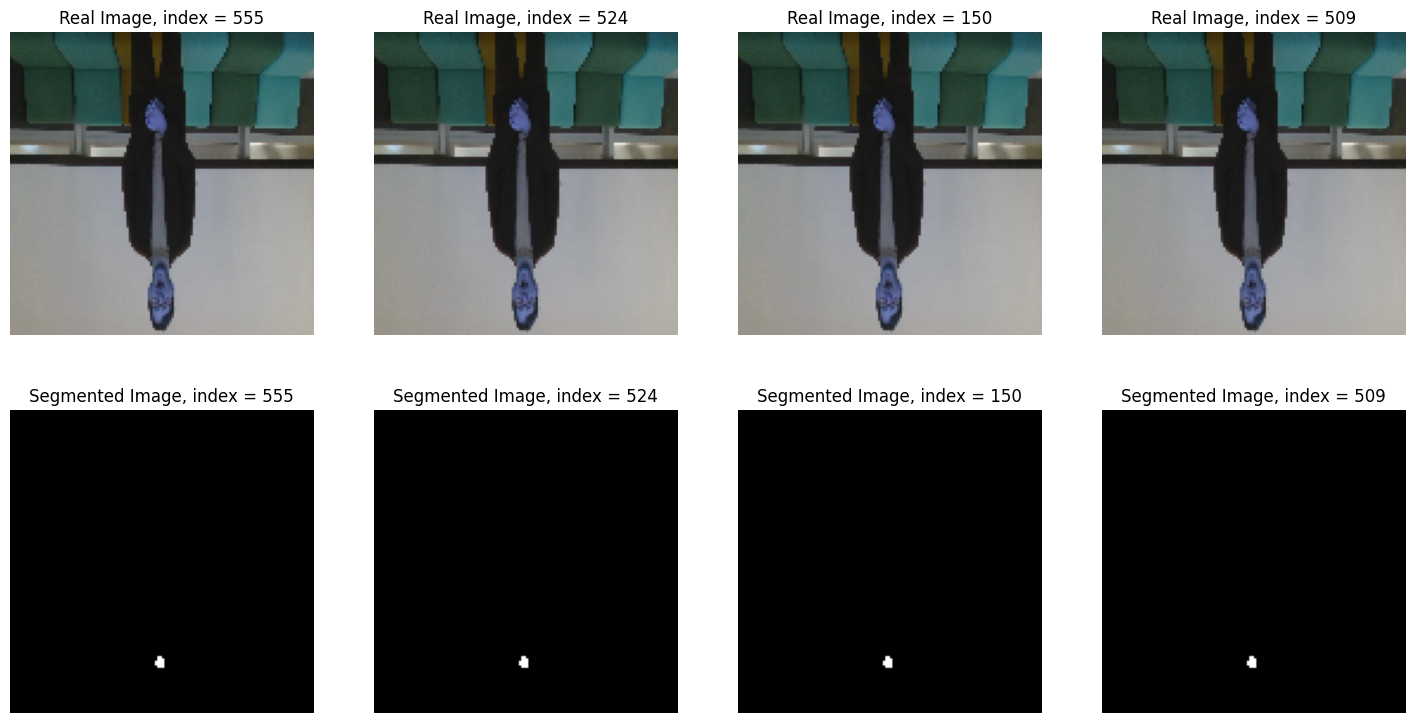

In [11]:
plot_images(images_augmented, masks_augmented,4)

In [101]:
def to_tensor(image_list, mask_list):
    tensor_images = tf.convert_to_tensor(tf.cast(np.array(image_list),  dtype = tf.float32))/255
    tensor_masks = tf.convert_to_tensor(tf.cast(np.array(mask_list), dtype= tf.float32))/255
    return tensor_images, tensor_masks

In [102]:
images, masks = to_tensor(images, masks)

I0000 00:00:1744188994.200290    1181 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [103]:
#splitting the images and masks into train, test and split
train_split = tf.cast(tf.round(len(images)*0.6) - 1, dtype = tf.int32)
test_val_split = tf.cast(tf.round(len(images)*0.2), dtype = tf.int32)

images_train = images[:train_split]
masks_train = masks[:train_split]

images_val = images[train_split:train_split + test_val_split]
masks_val = masks[train_split:train_split + test_val_split]

images_test = images[train_split + test_val_split:]
masks_test = masks[train_split + test_val_split:]

del images, masks

print(f'The length of images and masks for training is {len(images_train)} and {len(masks_train)} respectively')
print(f'The length of images and masks for validation is {len(images_val)} and {len(masks_val)} respectively')
print(f'The length of images and masks for testing is {len(images_test)} and {len(masks_test)} respectively')

The length of images and masks for training is 527 and 527 respectively
The length of images and masks for validation is 176 and 176 respectively
The length of images and masks for testing is 177 and 177 respectively


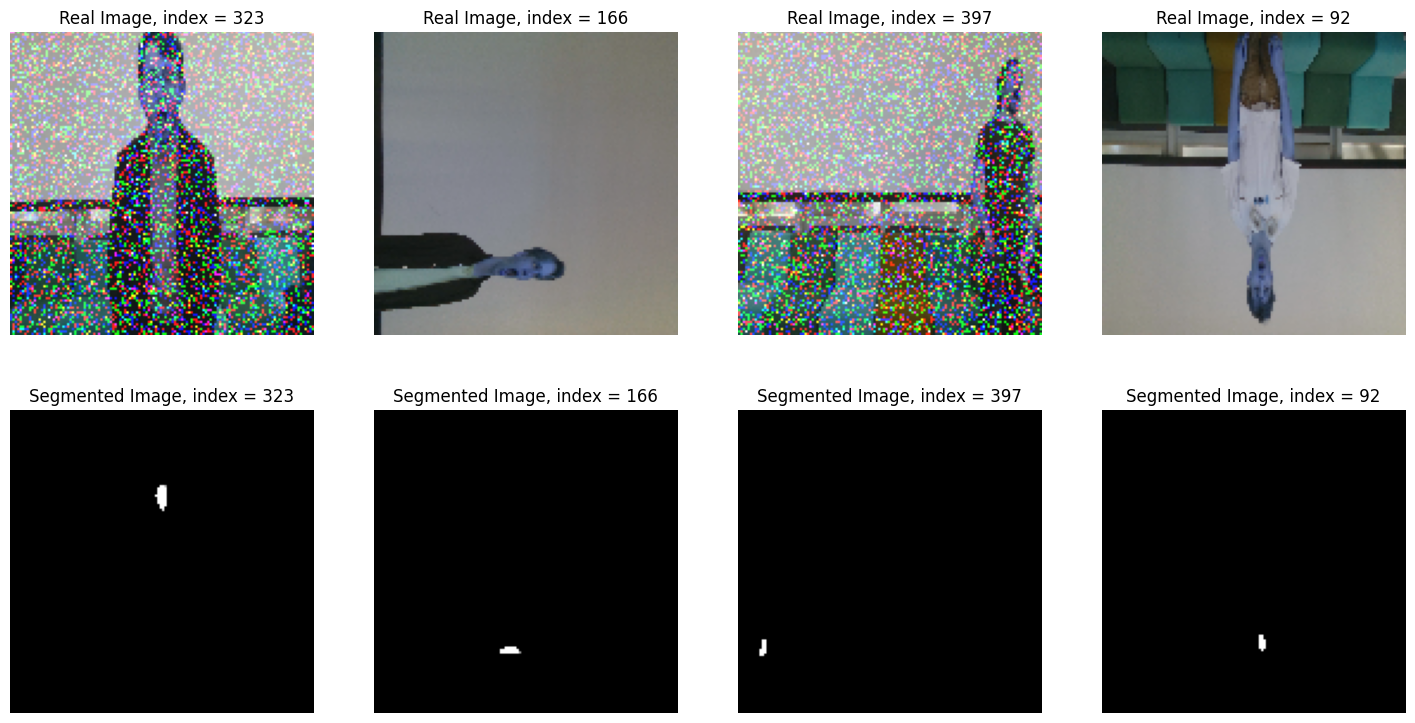

In [104]:
plot_images(images_train, masks_train,4)

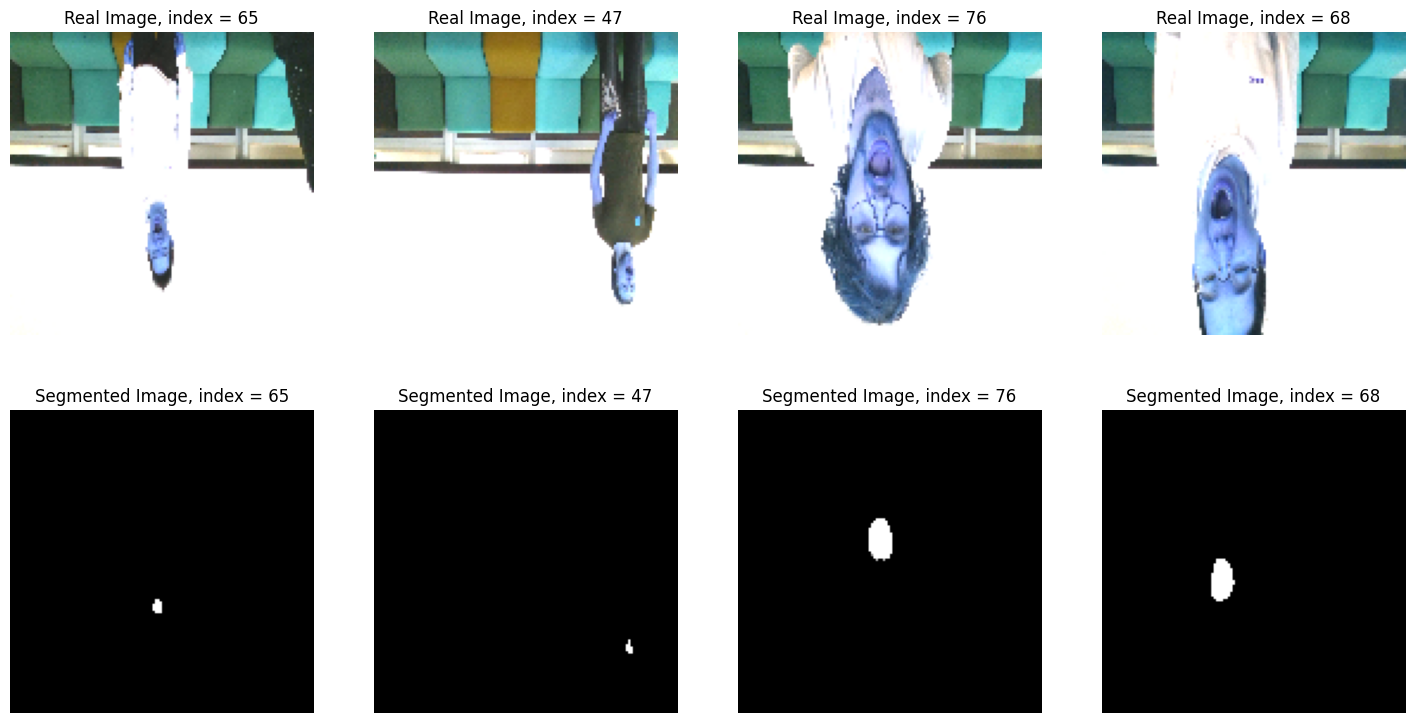

In [105]:
plot_images(images_val, masks_val,4)

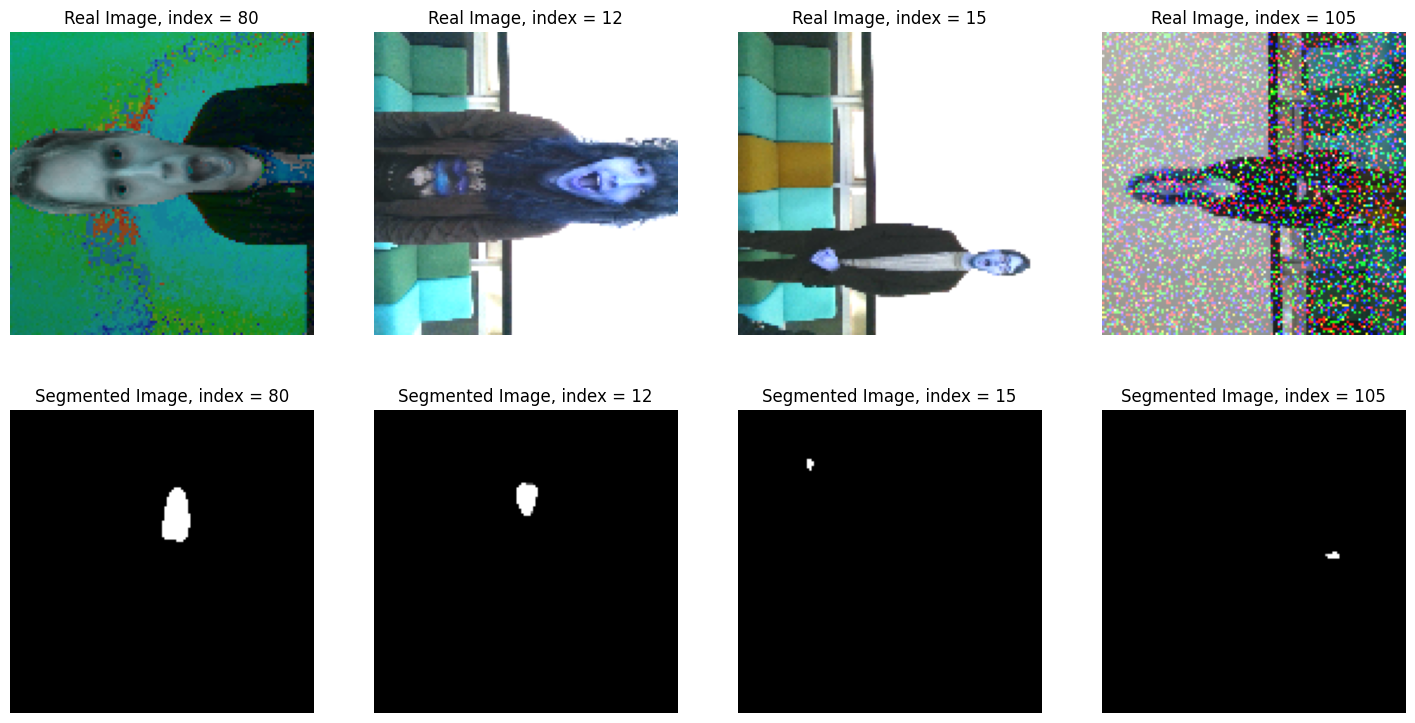

In [106]:
plot_images(images_test, masks_test,4)

In [107]:
#Converting the list of tensors into batches to efficiently train the model, computation-wise
batch_size = 5

train_data = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
train_data = train_data.batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
val_data = val_data.batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((images_test, masks_test))
test_data = test_data.batch(batch_size)

In [108]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [109]:
unet = unet()
unet.compile(loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy', dice_coefficient])
unet.summary()

Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 25,808,193 (98.45 MB)

 Trainable params: 25,808,193 (98.45 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [111]:
unet_history = unet.fit(train_data,validation_data=[val_data],
                        epochs = 50, callbacks = [early_stopping])

Epoch 1/50


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 128, 128, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • training=True
  • mask=None

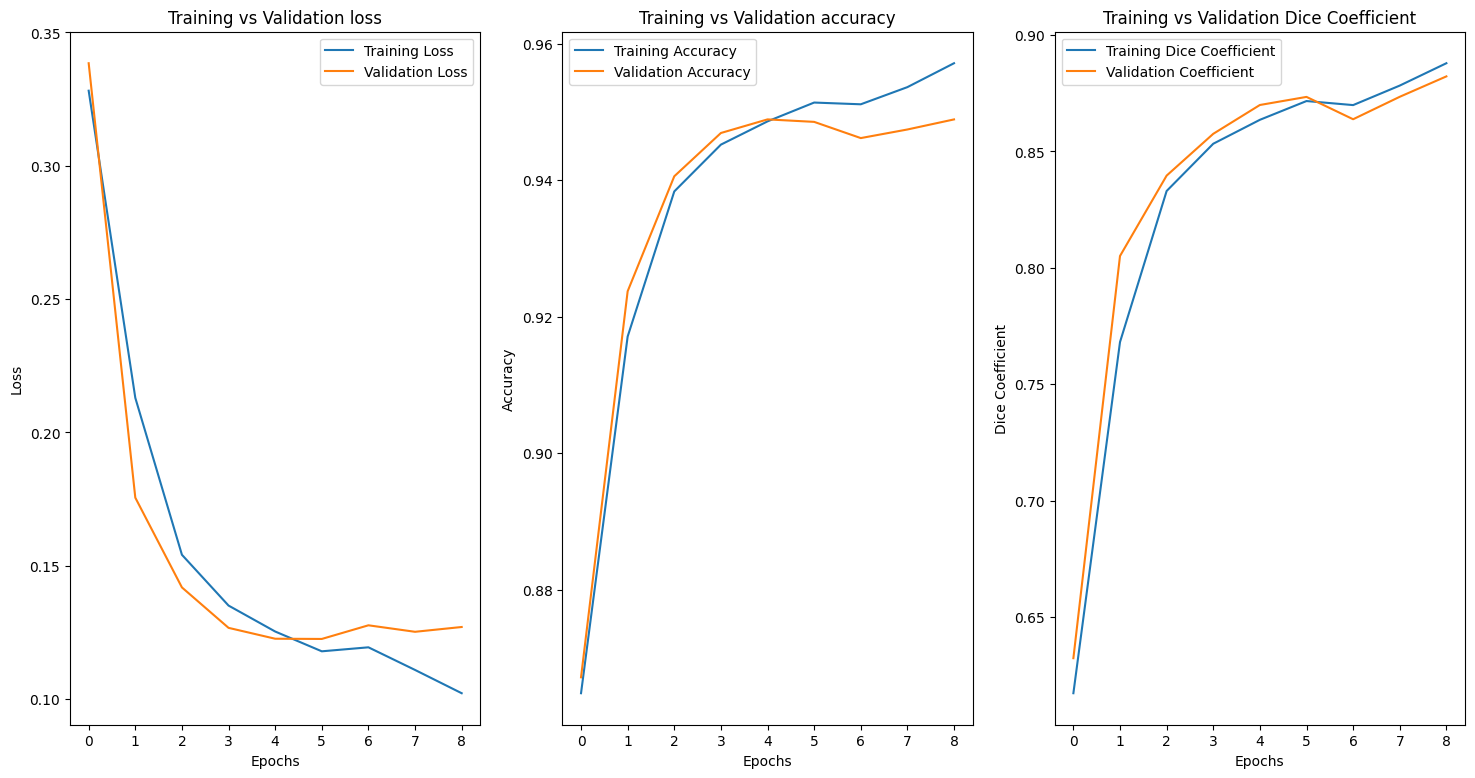

In [23]:
#Plotting the loss and accuracy during training and validation
plt.figure(figsize = (18, 9))
plt.subplot(1,3,1)
plt.plot(unet_history.history['loss'])
plt.plot(unet_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.subplot(1,3,2)
plt.plot(unet_history.history['accuracy'])
plt.plot(unet_history.history['val_accuracy'])
plt.title('Training vs Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.subplot(1,3,3)
plt.plot(unet_history.history['dice_coefficient'])
plt.plot(unet_history.history['val_dice_coefficient'])
plt.title('Training vs Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(['Training Dice Coefficient', 'Validation Coefficient'])

In [24]:
unet.evaluate(test_data)

401/401 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9602 - dice_coefficient: 0.8993 - loss: 0.0971


[0.09472331404685974, 0.9615143537521362, 0.8986429572105408]

In [25]:
#Function to plot the predictions with orginal image, original mask and predicted mask
def plot_preds(idx):
    plt.figure(figsize = (15, 15))
    test_img = images_test[idx]
    test_img = tf.expand_dims(test_img, axis = 0)
    test_img = tf.expand_dims(test_img, axis = -1)
    pred = unet.predict(test_img)
    pred = pred.squeeze()
    thresh = pred > 0.5
    plt.subplot(1,3,1)
    plt.imshow(images_test[idx])
    plt.title(f'Original Image {idx}')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(masks_test[idx])
    plt.title('Actual Mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(thresh)
    plt.title('Predicted Mask')
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


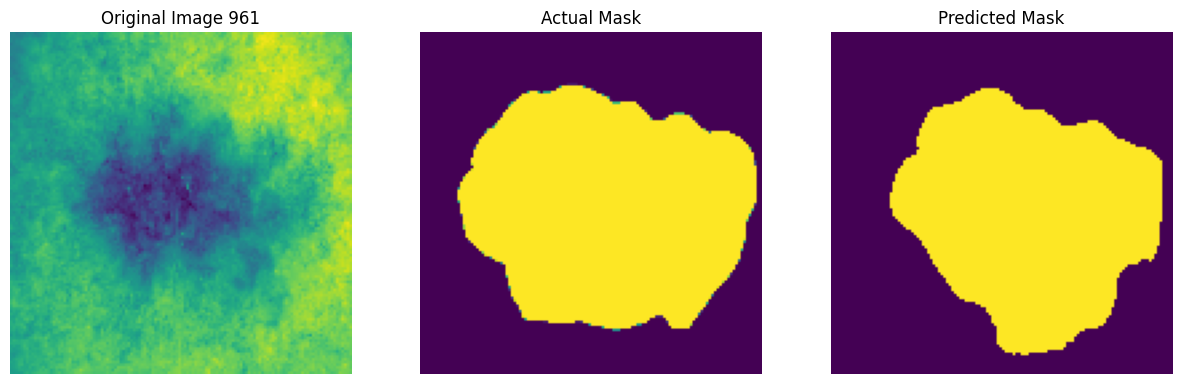

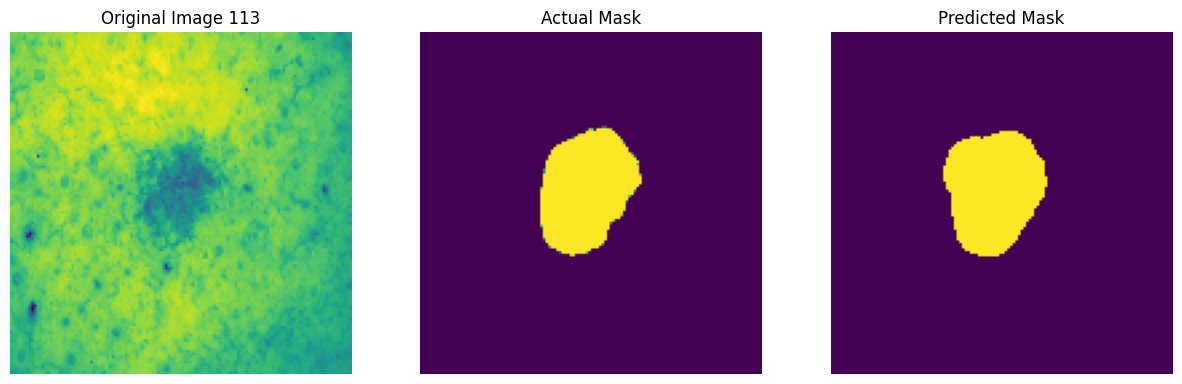

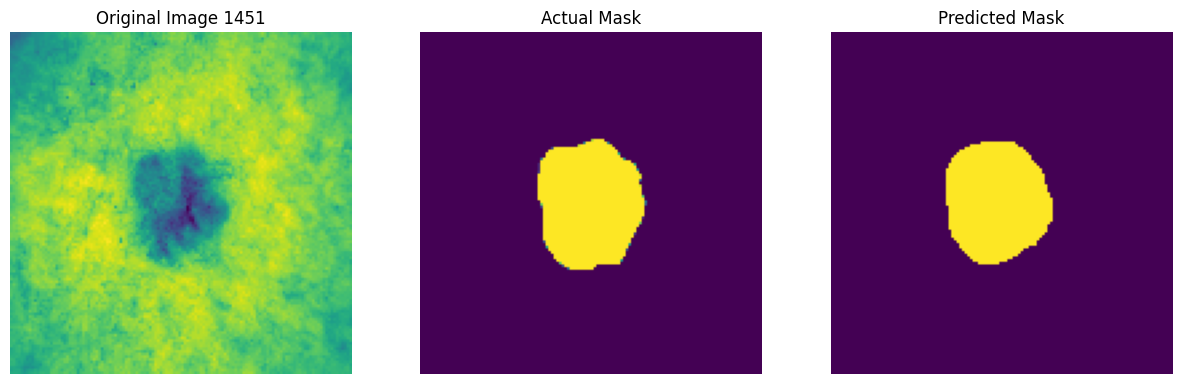

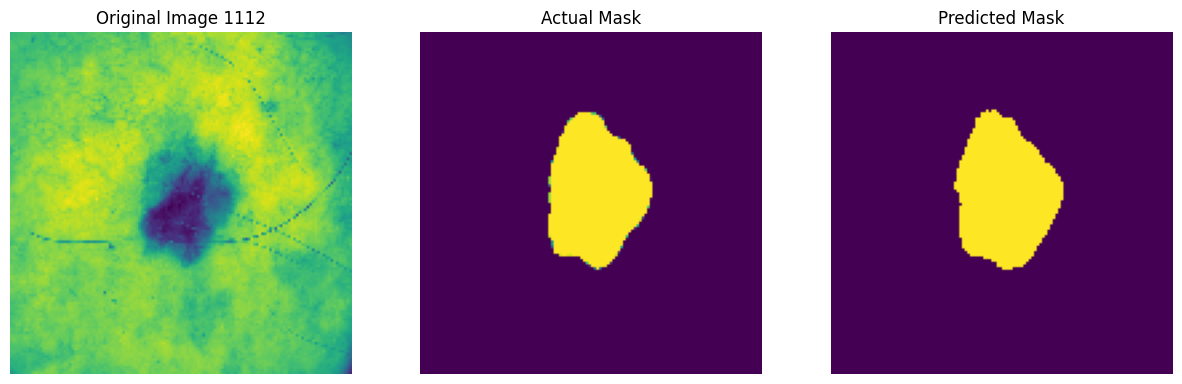

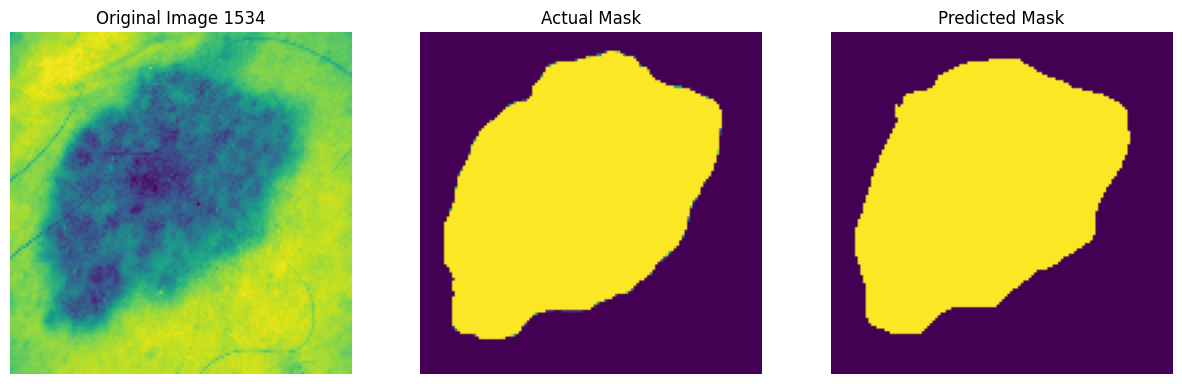

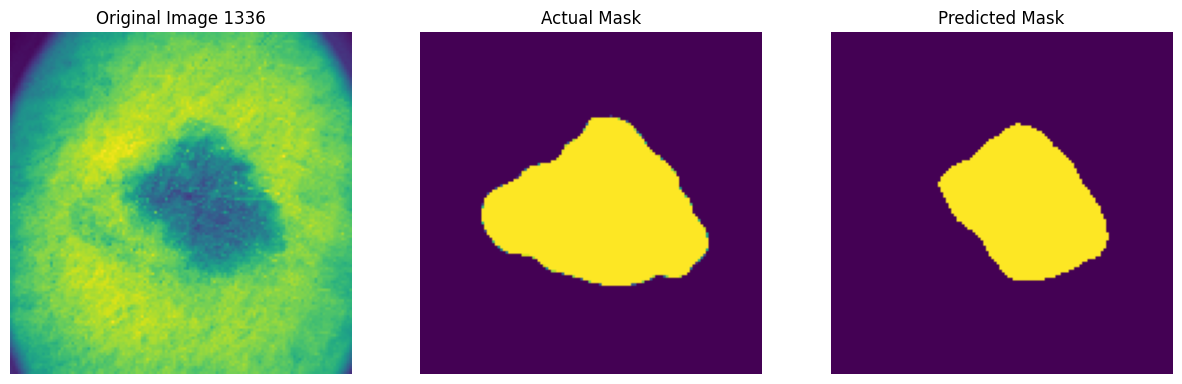

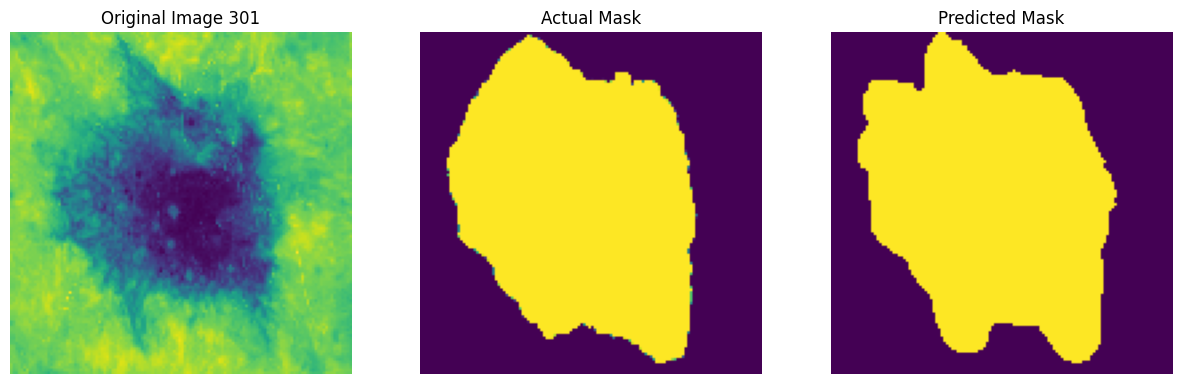

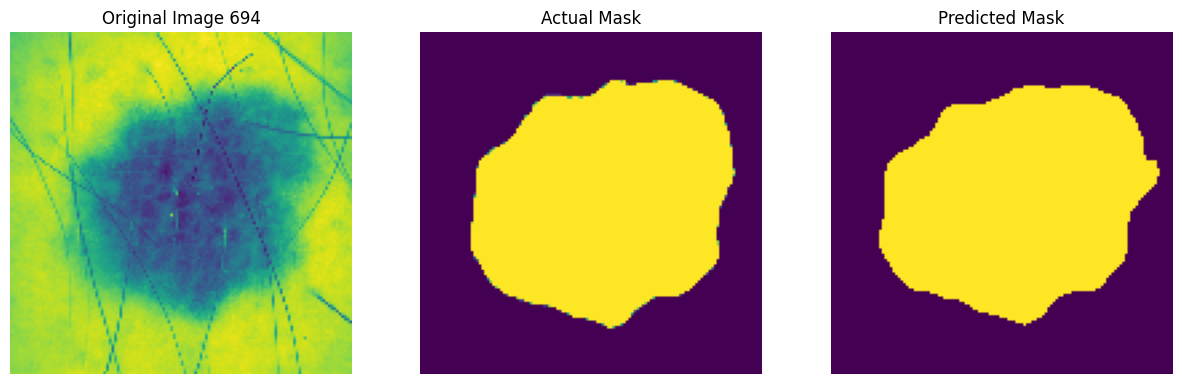

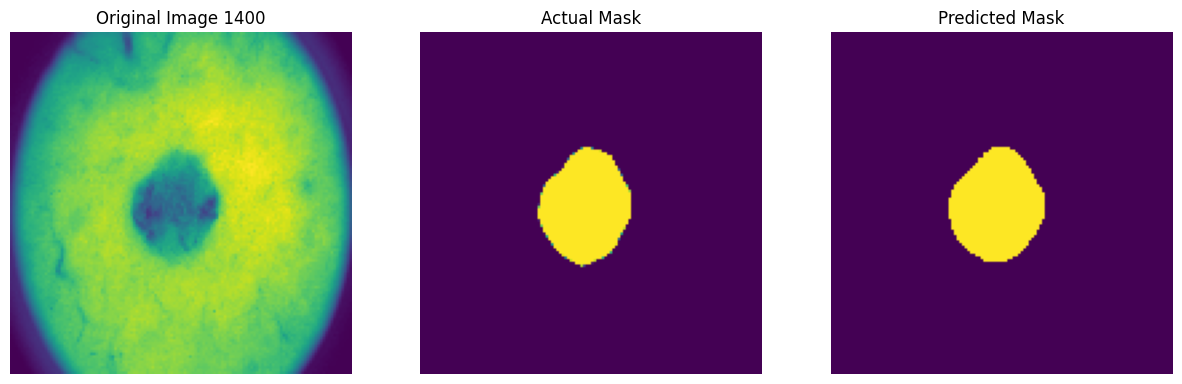

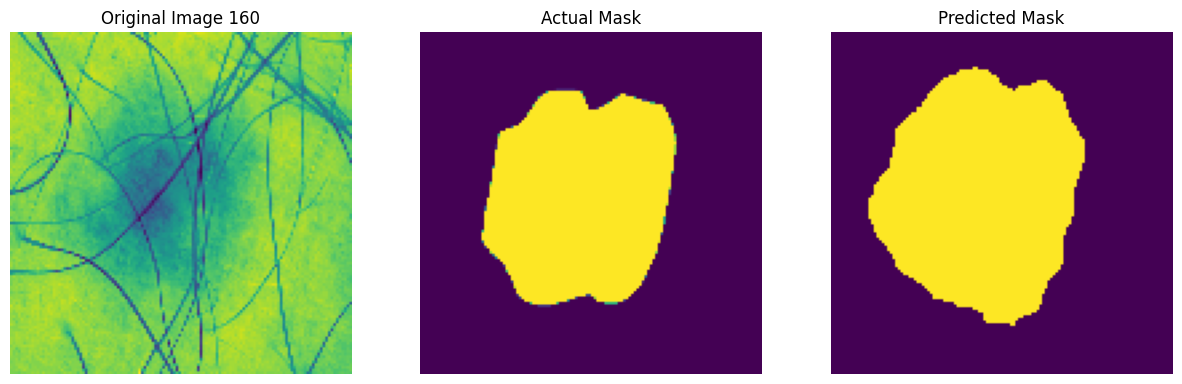

In [26]:
for i in [random.randint(0, 2000) for i in range(10)]:
    plot_preds(i)

In [28]:
#Saving the model
unet.save('unet_model.keras')